- [x] 95% overlap
- [x] shorten window (2s)
- [x] remove test-train split

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pywt
from scipy import signal
from tqdm import tqdm

%matplotlib inline

## Load data

In [2]:
data_path = "Data/GeneratedData/combined_data/"
base_path = os.getcwd()

# REST
IDD = np.load(os.path.join(data_path, "IDD_rest.npy"))
TDC = np.load(os.path.join(data_path, "TDC_rest.npy"))

# MUSIC
# IDD = np.load(os.path.join(data_path, "IDD_music.npy"))
# TDC = np.load(os.path.join(data_path, "TDC_music.npy"))

X = np.concatenate((IDD, TDC))
Y = [0]*len(IDD) + [1]*len(TDC)
Y = np.asarray(Y)

In [3]:
print(X.shape)
print(Y.shape)

(8470, 14, 256)
(8470,)


## Create Spectrograms

In [4]:
# Modified scalogram function from Fusion notebook
def scalogram(x, Hz, hz, start_sec, num_secs, w = 5.):
    ''' x = time series
        Hz = sampling rate in Hz of the input signal
        hz = desired sampling rate (by downsampling)
        start_sec = starting second in x
        num_secs = total number of seconds of our clip
        w = width parameter
        log =raw_seiz if true take log of spectrum values
    '''

    downsample = int(round(Hz / hz))
    X = x[start_sec * Hz: (start_sec + num_secs) * Hz : downsample]

    t, dt = np.linspace(start_sec, start_sec + num_secs, hz * num_secs, retstep = True)
    fs = 1 / dt

    freq = np.linspace(1, fs / 2, int(hz / 2))
    widths = w * fs / (2 * np.pi * freq)

    cwtm = signal.cwt(X,
                      signal.morlet2,
                      widths,
                      w = w)
    
    return cwtm

In [5]:
def generate_scalogram(data):
    scalogram_data = []
    for sample in tqdm(data):
        scalograms = []
        for channel in sample:
            scalograms.append(scalogram(channel, 128, 64, 0, 2))
        scalogram_data.append(np.concatenate(scalograms))
    return np.asarray(scalogram_data)

In [6]:
X_scalogram = generate_scalogram(X)

100%|██████████| 8470/8470 [04:19<00:00, 32.70it/s]


In [7]:
X_scalogram.shape

(8470, 448, 128)

In [8]:
def plot_scalograms(data, sample_index, N=128, hz=64, T=2, ts=0, w=4.):
    """
    :param N: signal sampling rate
    :param hz: downsampled sampling rate
    :param T: seconds
    :param ts: starting second
    :param w: 
    """

    t, dt = np.linspace(ts, ts + T, hz * T, retstep = True)
    fs = 1 / dt

    # freq = np.linspace(1, fs, int(hz))
    freq = np.linspace(1, (14 * (fs / 2)), (14 * int(hz / 2)))

    # print("t:", t)
    # print("freq:", freq)

    plt.rcParams['figure.figsize'] = 14, 50
    im = plt.pcolormesh(t, freq, np.abs(data[sample_index]), cmap = 'jet') # 'viridis'
    plt.show()


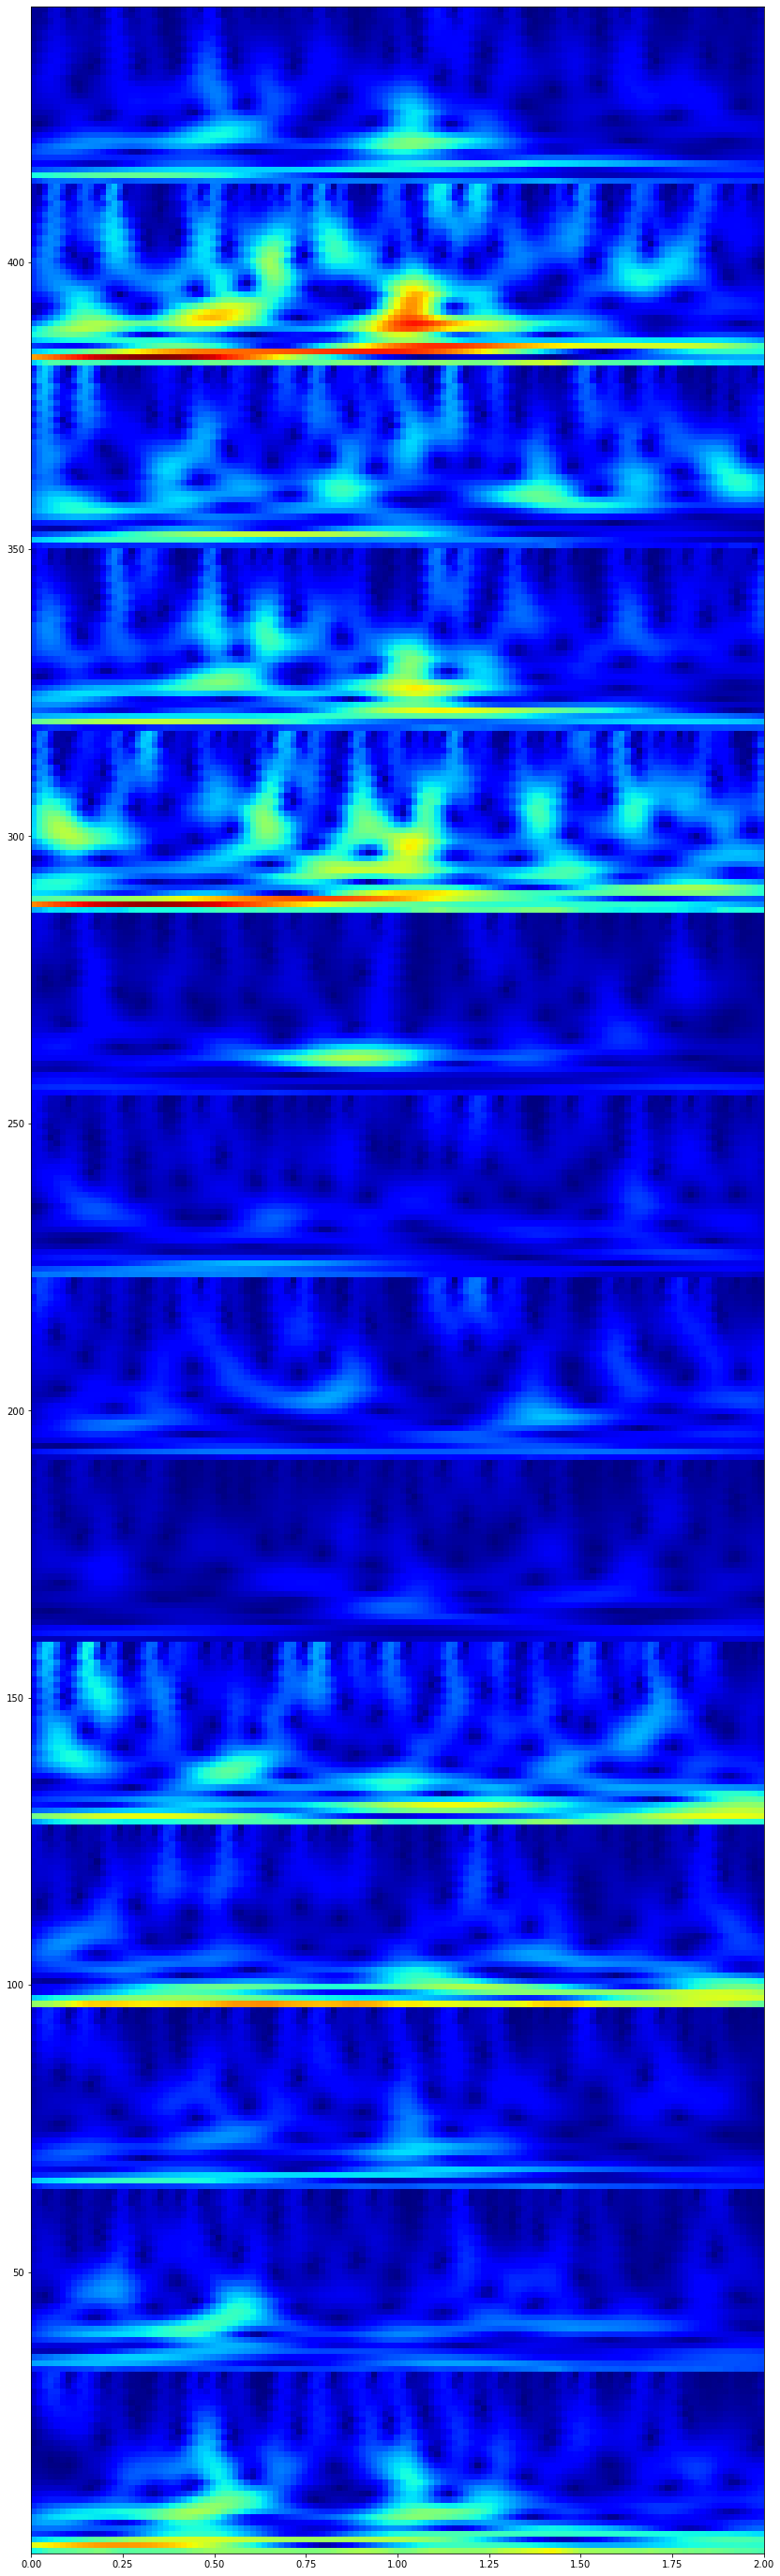

In [9]:
plot_scalograms(X_scalogram, 400)

In [10]:
# reshape data
X_scalogram = X_scalogram.reshape(X_scalogram.shape[0], X_scalogram.shape[1], X_scalogram.shape[2], 1)
X_scalogram.shape

(8470, 448, 128, 1)

## Test-Train split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_scalogram, Y, test_size=0.2, random_state=42)

In [12]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=22)

In [13]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
# print("X_test shape:", X_test.shape)
# print("y_test shape:", y_test.shape)
input_shape = X_train.shape[1:]

X_train shape: (6776, 448, 128, 1)
y_train shape: (6776,)
X_val shape: (1694, 448, 128, 1)
y_val shape: (1694,)


## Model

In [14]:
model = keras.Sequential([
    # Set input layer
    keras.layers.InputLayer(input_shape=input_shape),
    
    # Conv + Maxpooling
    keras.layers.Conv2D(8, (3, 3), padding="same", activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Normalization
    keras.layers.BatchNormalization(),
    
    # Flatten and convert from 3D to 1D
    keras.layers.Flatten(),
    
    # Sigmoid
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])


In [15]:
model.compile(
  optimizer='adam',
  loss='binary_crossentropy',
  metrics=['accuracy'],
)

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 448, 128, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 224, 64, 8)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 64, 8)        32        
_________________________________________________________________
flatten (Flatten)            (None, 114688)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 114689    
Total params: 114,801
Trainable params: 114,785
Non-trainable params: 16
_________________________________________________________________


In [17]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=10, 
                    batch_size=256,
                    validation_data=(X_val, y_val), 
                    verbose=1)

Train on 6776 samples, validate on 1694 samples
Epoch 1/10
6776/6776 [==============================] - 84s 12ms/sample - loss: 0.2218 - accuracy: 0.9337 - val_loss: 0.4272 - val_accuracy: 0.9221
Epoch 2/10
6776/6776 [==============================] - 79s 12ms/sample - loss: 0.0278 - accuracy: 0.9928 - val_loss: 0.3631 - val_accuracy: 0.9233
Epoch 3/10
6776/6776 [==============================] - 77s 11ms/sample - loss: 0.0121 - accuracy: 0.9959 - val_loss: 0.1127 - val_accuracy: 0.9717
Epoch 4/10
6776/6776 [==============================] - 80s 12ms/sample - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.0453 - val_accuracy: 0.9888
Epoch 5/10
6776/6776 [==============================] - 76s 11ms/sample - loss: 0.0029 - accuracy: 0.9996 - val_loss: 0.0333 - val_accuracy: 0.9900
Epoch 6/10
6776/6776 [==============================] - 81s 12ms/sample - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0.0242 - val_accuracy: 0.9923
Epoch 7/10
6776/6776 [==============================] - 78s 11ms

* Music
    * Validation accuracy: 99.47%
    * Validation loss: 0.0161
* Rest
    * Validation accuracy: 99.53%
    * Validation loss: 0.0140


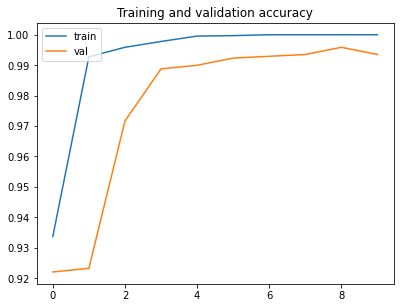

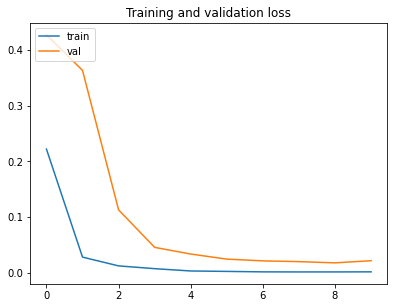

In [26]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))
plt.figure(figsize=(6.4,4.8))
# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
# plt.legend(['train'], loc='upper left')


plt.figure(figsize=(6.4,4.8))

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')
plt.legend(['train', 'val'], loc='upper left')

In [19]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
#
# print('Test accuracy:', test_acc)
# print('Test loss:', test_loss)